In [1]:
library(foreign)
library(ggplot2)
library(MASS)

### Examples of negative binomial regression

### Description of the data

In [2]:
dat <- read.dta("./datasets/nb_data.dta")
dat <- within(dat, {
       prog <- factor(prog, levels = 1:3, labels = c("General", "Academic", "Vocational"))
       id <- factor(id)})
summary(dat)

       id         gender         math          daysabs               prog    
 1001   :  1   female:160   Min.   : 1.00   Min.   : 0.000   General   : 40  
 1002   :  1   male  :154   1st Qu.:28.00   1st Qu.: 1.000   Academic  :167  
 1003   :  1                Median :48.00   Median : 4.000   Vocational:107  
 1004   :  1                Mean   :48.27   Mean   : 5.955                   
 1005   :  1                3rd Qu.:70.00   3rd Qu.: 8.000                   
 1006   :  1                Max.   :99.00   Max.   :35.000                   
 (Other):308                                                                 

<ggproto object: Class FacetGrid, Facet, gg>
    compute_layout: function
    draw_back: function
    draw_front: function
    draw_labels: function
    draw_panels: function
    finish_data: function
    init_scales: function
    map_data: function
    params: list
    setup_data: function
    setup_params: function
    shrink: TRUE
    train_scales: function
    vars: function
    super:  <ggproto object: Class FacetGrid, Facet, gg>

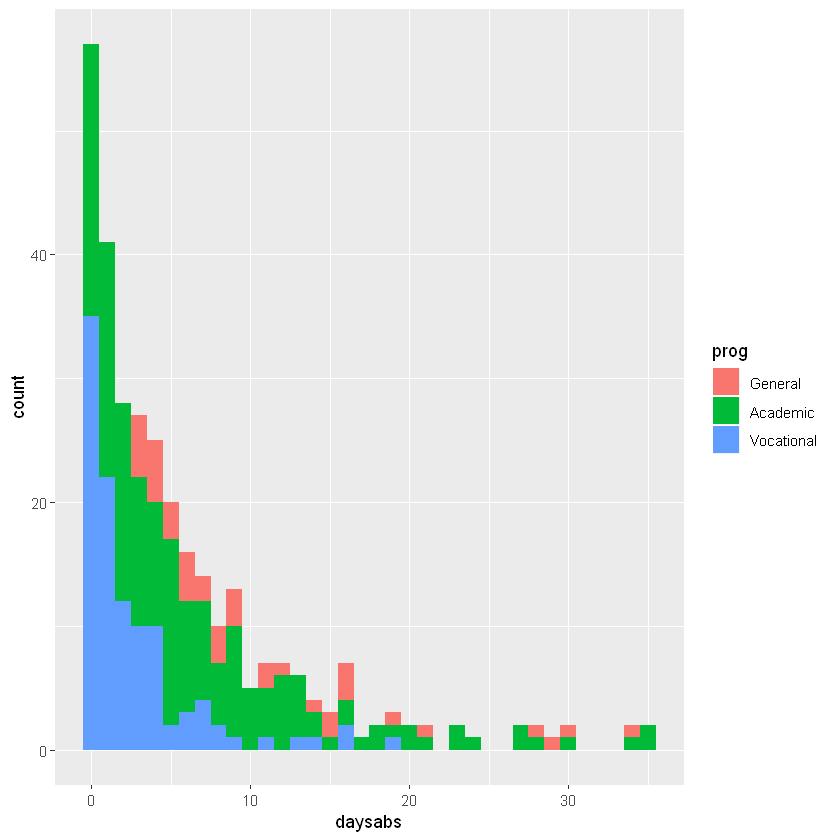

In [3]:
ggplot(dat, aes(daysabs, fill = prog)) + geom_histogram(binwidth = 1)
    facet_grid(prog ~ ., margins = TRUE, scales = "free")

In [4]:
with(dat, tapply(daysabs, prog, function(x) {sprintf("M (SD) = %1.2f (%1.2f)", mean(x), sd(x))}))

General                Academic              Vocational 
"M (SD) = 10.65 (8.20)"  "M (SD) = 6.93 (7.45)"  "M (SD) = 2.67 (3.73)"

### Analysis methods you might consider

### Negative binomial regression analysis

In [5]:
summary(m1 <- glm.nb(daysabs ~ math + prog, data = dat))


Call:
glm.nb(formula = daysabs ~ math + prog, data = dat, init.theta = 1.032713156, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1547  -1.0192  -0.3694   0.2285   2.5273  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.615265   0.197460  13.245  < 2e-16 ***
math           -0.005993   0.002505  -2.392   0.0167 *  
progAcademic   -0.440760   0.182610  -2.414   0.0158 *  
progVocational -1.278651   0.200720  -6.370 1.89e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Negative Binomial(1.0327) family taken to be 1)

    Null deviance: 427.54  on 313  degrees of freedom
Residual deviance: 358.52  on 310  degrees of freedom
AIC: 1741.3

Number of Fisher Scoring iterations: 1


              Theta:  1.033 
          Std. Err.:  0.106 

 2 x log-likelihood:  -1731.258 

In [6]:
m2 <- update(m1, . ~ . - prog)
anova(m1, m2)

Model,theta,Resid. df,2 x log-lik.,Test,df,LR stat.,Pr(Chi)
math,0.8558565,312,-1776.306,,NA,NA,NA
math + prog,1.0327132,310,-1731.258,1 vs 2,2,45.04798,1.65179e-10


### Checking model assumption

In [7]:
m3 <- glm(daysabs ~ math + prog, family = "poisson", data = dat)
pchisq(2 * (logLik(m1) - logLik(m3)), df = 1, lower.tail = FALSE)

'log Lik.' 2.157298e-203 (df=5)

In [8]:
(est <- cbind(Estimate = coef(m1), confint(m1)))

Waiting for profiling to be done...


,Estimate,2.5 %,97.5 %
(Intercept),2.615265446,2.24205576,3.012935926
math,-0.005992988,-0.01090086,-0.001066615
progAcademic,-0.440760012,-0.81006586,-0.092643481
progVocational,-1.278650721,-1.68348970,-0.890077623


In [9]:
exp(est)

,Estimate,2.5 %,97.5 %
(Intercept),13.6708448,9.4126616,20.3470498
math,0.9940249,0.9891583,0.9989340
progAcademic,0.6435471,0.4448288,0.9115184
progVocational,0.2784127,0.1857247,0.4106239


The form of the model equation for negative binomial regression is the same as that for Poisson regression. The log of the outcome is predicted with a linear combination of the predictors:

$ ln(\widehat{daysabs_i}) = Intercept + b_1(prog_i = 2) + b_2(prog_i = 3) + b_3math_i \$

therefore

$ \widehat{daysabs_i} = e^{Intercept + b_1(prog_i = 2) + b_2(prog_i = 3) + b_3math_i} = e^{Intercept}e^{b_1(prog_i = 2)}e^{b_2(prog_i = 3)}e^{b_3math_i} $

### Predicted values

In [10]:
newdata1 <- data.frame(math = mean(dat$math), prog = factor(1:3, levels = 1:3, labels = levels(dat$prog)))
newdata1$phat <- predict(m1, newdata1, type = "response")
newdata1

math,prog,phat
48.26752,General,10.236899
48.26752,Academic,6.587927
48.26752,Vocational,2.850083


In [11]:
newdata2 <- data.frame(
            math = rep(seq(from = min(dat$math), to = max(dat$math), length.out = 100), 3),
            prog = factor(rep(1:3, each = 100), levels = 1:3, labels =
            levels(dat$prog)))

newdata2 <- cbind(newdata2, predict(m1, newdata2, type = "link", se.fit=TRUE))

newdata2 <- within(newdata2, {
            DaysAbsent <- exp(fit)
            LL <- exp(fit - 1.96 * se.fit)
            UL <- exp(fit + 1.96 * se.fit)
            })

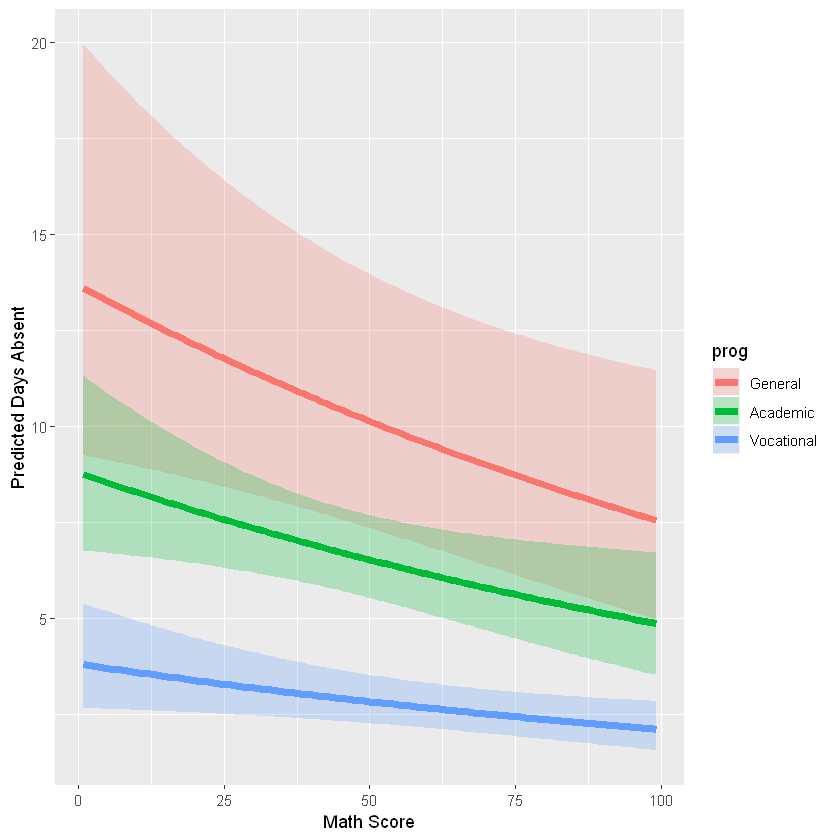

In [12]:
ggplot(newdata2, aes(math, DaysAbsent)) +
    geom_ribbon(aes(ymin = LL, ymax = UL, fill = prog), alpha = .25) + 
    geom_line(aes(colour = prog), size = 2) + labs(x = "Math Score", y = "Predicted Days Absent")

### Things to consider